In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [3]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

    return fig

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [8]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [9]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [10]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/multivariate_grou

In [11]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [12]:
predictor = estimator.train(dataset_train, num_workers=8)

  0%|          | 0/99 [00:00<?, ?it/s]/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Time

In [13]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [14]:
forecasts = list(forecast_it)
targets = list(ts_it)

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/transform/feature.py:343:

In [15]:
dataframe= pd.DataFrame(forecasts)
dataframe.to_csv('forecasts.csv')

/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},


In [16]:
for i, forecast in enumerate(forecasts[:5]):
    print(i)
    #print(forecast.dim)
    print(forecast.start_date)
    print(forecast.mean)

0
2014-09-01 01:00:00
[[ 68.551994  94.42268   51.221188 ... 140.17572  219.03151   74.016624]
 [ 66.29155   89.83469   50.146393 ... 134.43678  194.26051   67.15359 ]
 [ 68.31506   90.99665   51.75455  ... 140.5896   208.23355   71.36397 ]
 ...
 [ 97.190155 140.16148   80.313095 ... 188.33266  296.7469   105.09532 ]
 [ 84.94388  106.379364  63.330864 ... 153.2638   242.32687   86.01953 ]
 [ 71.27066   93.644264  53.16033  ... 144.08197  223.80888   71.97029 ]]
1
2014-09-02 01:00:00
[[ 67.55862  106.36322   52.55277  ... 160.42064  217.3937    80.38013 ]
 [ 72.11524  110.78087   51.969017 ... 164.94038  207.6644    84.4486  ]
 [ 68.75453  115.59943   55.812767 ... 163.08984  218.7377    80.835045]
 ...
 [102.424324 162.22179   84.49306  ... 219.15805  320.56964  122.565506]
 [ 87.33409  131.83115   65.699036 ... 181.74117  264.4909    98.06797 ]
 [ 75.829216 119.63721   59.552933 ... 172.05531  219.60603   85.01493 ]]
2
2014-09-03 01:00:00
[[ 64.66867  112.20762   55.599255 ... 137.273

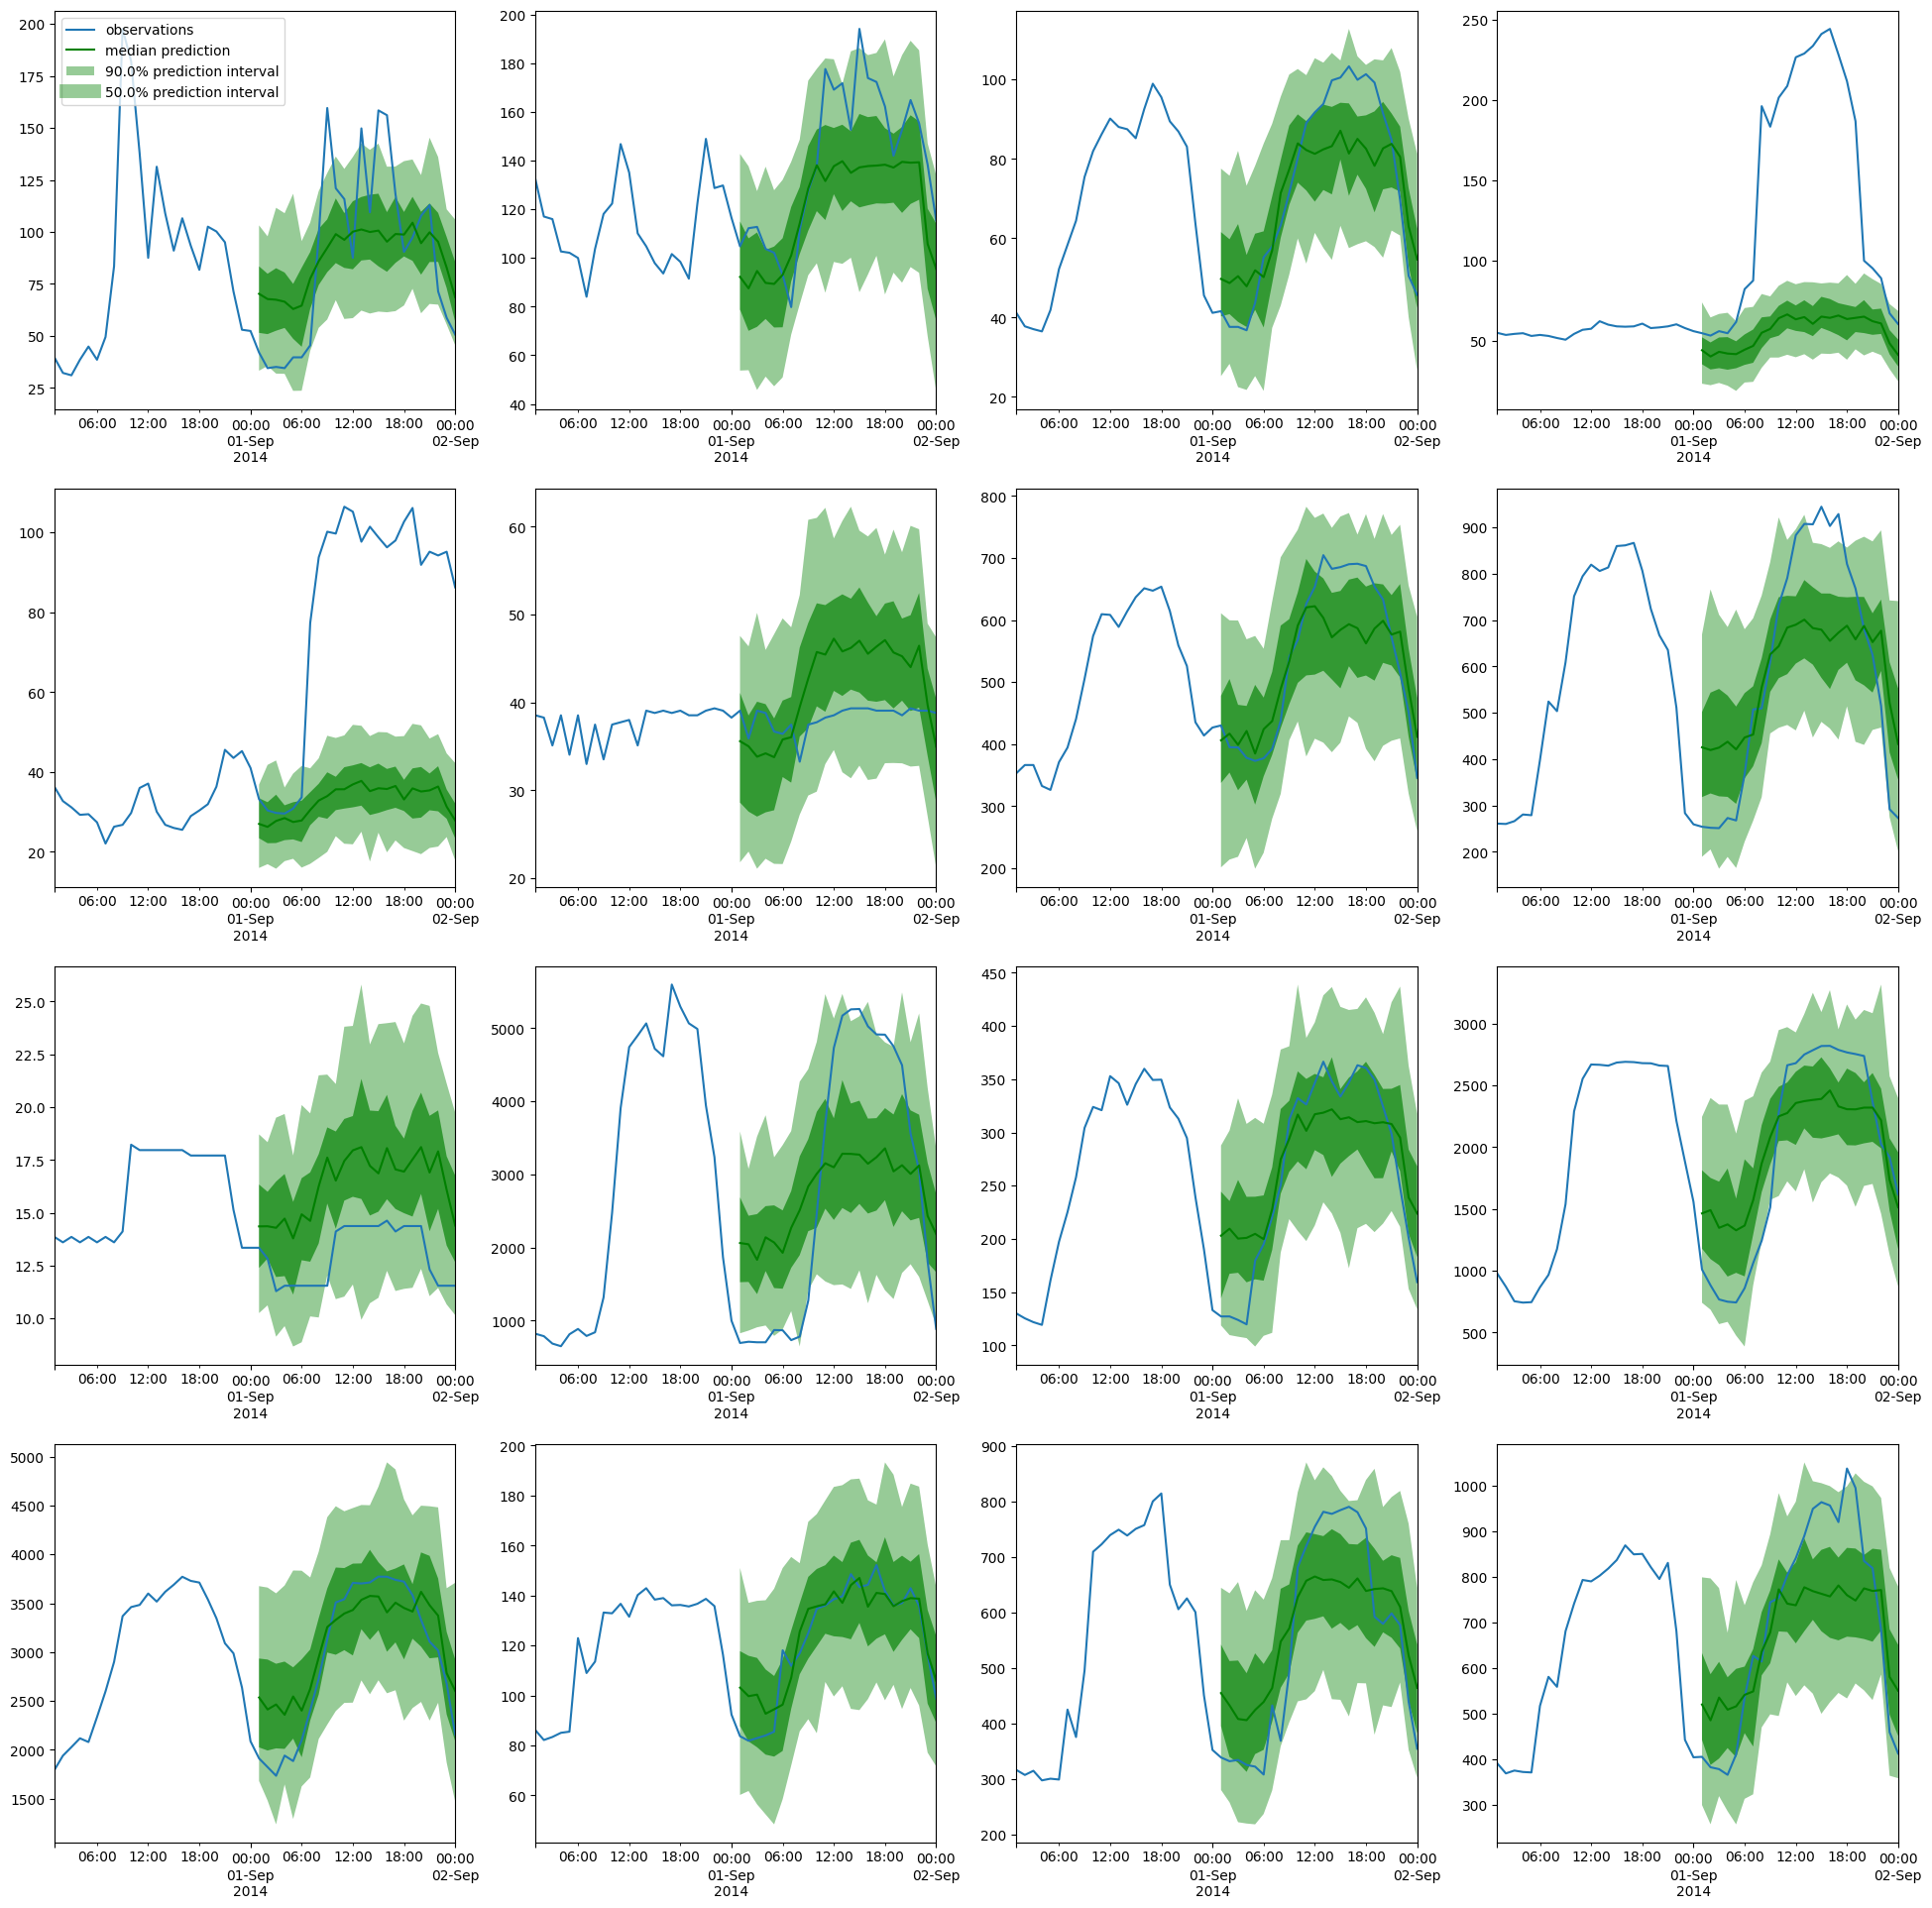

In [17]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [18]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [19]:
#agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

In [20]:

print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])


NameError: name 'agg_metric' is not defined

In [21]:
#gradio ui establishment
import gradio as gr

def generate_plot():
    # 调用 plot() 函数生成图像，并捕获返回的 fig 对象
    fig = plot(
        target=targets[0],
        forecast=forecasts[0],
        prediction_length=dataset.metadata.prediction_length,
    )
    return fig

def generate_text():
    df= pd.DataFrame(forecasts)
    file_path= 'prediction_data.csv'
    df.to_csv(file_path,index=False)
    return file_path


with gr.Blocks() as demo:
    with gr.Tab(label= 'Timegrad'):
        with gr.Row():
            input= gr.File(label= 'Upload file')

            with gr.Column():
                button1= gr.Button(value= 'Electricity')
                button2= gr.Button(value= 'Stocks')
                button3= gr.Button(value= '3')
            
            with gr.Column():
                generate_button= gr.Button(value= 'Generate')
                with gr.Row():
                    dropdown= gr.Dropdown(choices=['Image only', 'Image and Text'], label= 'Format')

        
        with gr.Row():
            with gr.Column():
                #a title
                gr.Markdown('diffusion model parameters')
                with gr.Row():
                    dropdown_rnn= gr.Dropdown(choices=['LSTM', 'GRU'], label= 'RNN')
                    slider_step= gr.Slider(minimum= 1, maximum= 1000, step= 10, label= 'Steps')

                gr.Markdown('train parameters')
                with gr.Row():
                    slider_lr= gr.Slider(minimum= 0.00001, maximum= 0.01, step= 0.00001, label= 'Learning rate')
                    slider_epoch= gr.Slider(minimum= 1, maximum= 20, step= 1, label= 'training epoch')
                with gr.Row():
                    slider_batchsize= gr.Slider(minimum= 0, maximum= 10, step= 1, label= 'batch_size' )
                    slider_beta_end= gr.Slider(minimum= 0.00001, maximum= 0.01, step= 0.00001, label= 'beta_end')
                text_prediction_length= gr.Textbox(label= 'prediction length')

        with gr.Row():
            with gr.Column():
                prediction_img= gr.Plot()
                generate_button.click(fn=generate_plot, inputs=None, outputs= prediction_img)
                prediction_text= gr.File(label= 'prediction data')
                generate_button.click(fn=generate_text, inputs=None, outputs= prediction_text)





demo.launch(share=True, server_port=6006)   

Running on local URL:  http://127.0.0.1:6006
IMPORTANT: You are using gradio version 3.48.0, however version 4.44.1 is available, please upgrade.
--------

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:31: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  "kwargs": {"freq": v.freqstr if v.freq else None},
/root/miniconda3/envs/timegrad2/lib/python3.8/site-packages/gluonts/core/serde/pd.py:3